# Wprowadzenie do równań różniczkowych

W ramach poznawania podstawowych narzędzi do *obsługi* równań różniczkowych w Pythonie omówimy zarówno symboliczne, jak i numeryczne podejście do rozwiązywania równań różniczkowych zwyczajnych. Wykorzystamy w tym celu pakiet `SymPy` (do obliczeń symbolicznych) oraz funkcje z modułu `integrate` w pakiecie `SciPy`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import sympy
from ipywidgets import interact
import ipywidgets as widgets

Musimy jeszcze zadbać o ładne wyświetlanie wyników obliczeń symbolicznych.

In [2]:
sympy.init_printing()

## Obliczenia symboliczne i obliczanie pochodnych

Pythona można wykorzystać do prostych obliczeń symbolicznych (podobnie jak *Wolfram Mathematica*), chociaż wymaga to nieco zachodu.

In [3]:
x, y = sympy.symbols('x, y')
expr = sympy.expand((x + y)**2)
expr

Wyrażenia tego typu można bez trudu różniczkować, całkować, itd.:

In [4]:
sympy.diff(expr, x)

Można obliczać pochodne dowolnie wysokiego rzędu - wystarczy podawać kolejne zmienne, po których chcemy różniczkować:

In [5]:
sympy.diff(sympy.exp(x * y), x, x)

In [6]:
sympy.diff(sympy.exp(x * y), x, 2)

Różniczkowanie można wywołać także jako metodę:

In [7]:
sympy.exp(- x**2).diff(x)

Można także zapamiętać wyrażenie jako pochodną, ale bez obliczania jej:

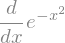

In [8]:
deriv = sympy.Derivative(sympy.exp(- x**2), x)
deriv

Wówczas, aby jednak wykonać obliczenia wystarczy metoda `doit`:

In [9]:
deriv.doit()

Pakiet `SymPy` pozwala też na wprowadzenie wyrażeń, w których rząd pochodnej nie jest konkretnie zdefiniowany, jednak nie rozwinie ich:

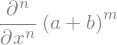

In [10]:
m, n, a, b = sympy.symbols('m, n, a, b')
expr = (a + b)**m
expr.diff((x, n))

Analogiczna składnia obowiązuje przy całkowaniu - wykorzystuje się wówczas funkcję `integrate` (do obliczania) oraz `Integral` (do wprowadzania).

Oczywiście można wprowadzać też funkcje (symboliczne) i na nich wykonywać obliczenia.

In [11]:
t, k, T0, Ta = sympy.symbols('t, k, T_0, T_a')
T = sympy.Function('T')
expr = T(t).diff(t) + k * (T(t) - Ta)

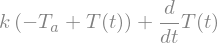

In [12]:
expr

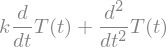

In [13]:
expr.diff(t)

Czasem przydaje się potraktować wyrażenie jako rowność - `SymPy` domyślnie przyrównuje wówczas wyrażenie do zera (jeśli nie podamy *prawej strony*):

C:\ProgramData\Anaconda3\lib\site-packages\sympy\core\relational.py:470: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  deprecated_since_version="1.5"


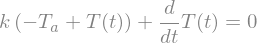

In [14]:
sympy.Eq(expr)

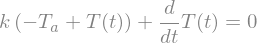

In [15]:
sympy.Eq(expr, 0)

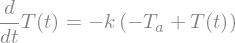

In [16]:
sympy.Eq(T(t).diff(t), - k * (T(t) - Ta))

Możemy też sprawdzić, czy podana funkcja jest rozwiązaniem danego równania:

In [17]:
sympy.Eq(expr,0).subs(T(t), Ta + (T0 - Ta) * sympy.exp(- k * t)).doit()

In [18]:
Tsol = Ta + (T0 - Ta) * sympy.exp(- k * t)
sympy.Eq(Tsol.diff(t) + k * (Tsol - Ta), 0)

In [19]:
sympy.checkodesol(expr, Tsol)

(True, 0)

## Równania różniczkowe - rozwiązania analityczne

Jeśli `SymPy` umie rozwiązać równanie różniczkowe, to robi to za pomocą funkcji `dsolve`:

In [20]:
ode = T(t).diff(t) + k * (T(t) - Ta)
ode_sol = sympy.dsolve(ode, T(t))
ode_sol

Kilka uwag:
* równanie można podać zarówno jako wyrażenie, wtedy jest przyrównywane do zera, albo jako równość `sympy.Eq(...)`,
* jeśli w równaniu występuje tylko jedna funkcja, to nie trzeba podawać jej jako argumentu.

Funkcja `dsolve` stara się rozpoznać rodzaj równania i znajduje jego **rozwiązanie ogólne**.

In [21]:
sympy.classify_ode(ode, T(t))

('separable',
 '1st_linear',
 'Bernoulli',
 'almost_linear',
 '1st_power_series',
 'lie_group',
 'nth_linear_constant_coeff_undetermined_coefficients',
 'nth_linear_constant_coeff_variation_of_parameters',
 'separable_Integral',
 '1st_linear_Integral',
 'Bernoulli_Integral',
 'almost_linear_Integral',
 'nth_linear_constant_coeff_variation_of_parameters_Integral')

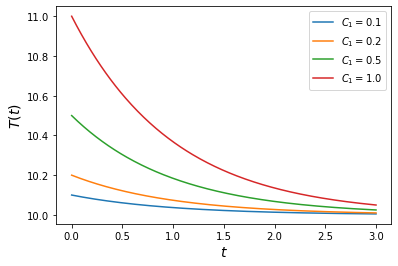

In [22]:
tt = np.linspace(0, 3, 250)
for C1 in [0.1, 0.2, 0.5, 1.0]:
    T_t = sympy.lambdify(t, ode_sol.rhs.subs({k: 1, Ta: 10, 'C1': C1}), 'numpy')
    plt.plot(tt, T_t(tt), label=r"$C_1 = %.1f$" % C1)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$T(t)$", fontsize=14)
plt.legend()
plt.show()

Pozostaje jeszcze kwestia warunków początkowych. Można próbować uwzględniać je ręcznie (rozwiązując odpowiednie równanie), ale można je podać też jako argument funkcji `dsolve`:

In [23]:
ivp_sol = sympy.dsolve(ode, T(t), ics={T(0): T0})
ivp_sol

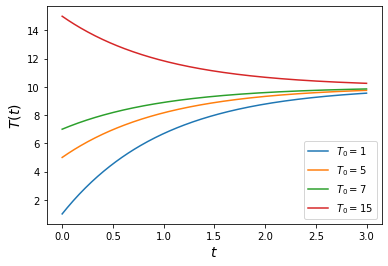

In [24]:
for t0 in [1, 5, 7, 15]:
    T_t = sympy.lambdify(t, ivp_sol.rhs.subs({k: 1, Ta: 10, T0: t0}), 'numpy')
    plt.plot(tt, T_t(tt), label=r"$T_0 = %.0f$" % t0)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$T(t)$", fontsize=14)
plt.legend()
plt.show()

Powyższy problem był dość trywialny, ale ta sama metoda może zostać użyta właściwie do dowolnego równania zwyczajnego (choć nie ma gwarancji, że rozwiązanie zostanie znalezione). Rozważmy teraz problem:
$$x''(t) + 2p x'(t) + w_0^2 x(t) = 0,$$
czyli problem oscylatora z tłumieniem.

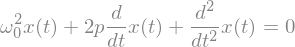

In [25]:
t, omega0, p = sympy.symbols('t, omega_0, p', positive=True)
x = sympy.Function('x')
ode = x(t).diff(t, 2) + 2 * p * x(t).diff(t) + omega0**2 * x(t)
sympy.Eq(ode, 0)

In [26]:
ode_sol = sympy.dsolve(ode, x(t))
ode_sol

Widać tutaj jeden z problemów: liczba pod pierwastkiem może być ujemna... Problemów jest więcej:

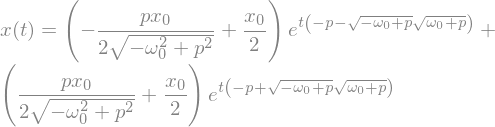

In [27]:
x0 = sympy.symbols('x_0')
ivp_sol = sympy.dsolve(ode, x(t), ics={x(0): x0, x(t).diff(t).subs(t, 0): 0})
ivp_sol

In [28]:
ivp_sol_crit = sympy.limit(ivp_sol.rhs, p, omega0)
ivp_sol_crit

Należy uważać przy interpretowaniu rozwiązań równań zwyczajnych, bo mogą nie uwzględniać wszystkich przypadków.

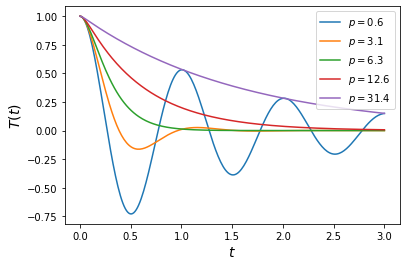

In [29]:
tt = np.linspace(0, 3, 250)
w0 = 2 * sympy.pi
for p0 in [0.1 * w0, 0.5 * w0, w0, 2.0 * w0, 5.0 * w0]:
    if p0 == w0:
        x_t = sympy.lambdify(t, ivp_sol_crit.subs({omega0: w0, x0: 1}), 'numpy')
    else:
        x_t = sympy.lambdify(t, ivp_sol.rhs.subs({omega0: w0, p: p0, x0: 1}), 'numpy')
    plt.plot(tt, x_t(tt).real, label=r"$p = %.1f$" % p0)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$T(t)$", fontsize=14)
plt.legend()
plt.show()

Czasami jednak `SymPy` nie potrafi poradzić sobie z rozwiązaniem równania. Warto tu wyróżnić trzy sytuacje.

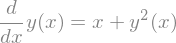

In [30]:
x = sympy.symbols('x')
y = sympy.Function('y')
f = y(x)**2 + x
sympy.Eq(y(x).diff(x), f)

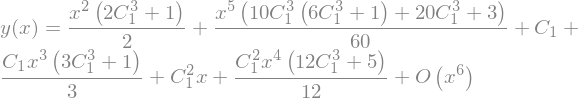

In [31]:
sympy.dsolve(y(x).diff(x) - f, y(x))

In [32]:
sympy.classify_ode(y(x).diff(x) - f, y(x))

('1st_power_series', 'lie_group')

Widzimy, że rozwiązanie powyższego problemu dane jest w postaci szeregu.

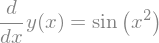

In [33]:
f = sympy.sin(x**2)
sympy.Eq(y(x).diff(x), f)

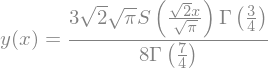

In [34]:
sympy.dsolve(y(x).diff(x) - f, y(x), ics={y(0): 0})

Tym razem pojawia nam się tajemnicza funkcja $S$ - jest to całka Fresnela, która jest w `SymPy` zdefiniowana... właśnie jako rozwiązanie takiego (analogicznego) równania.

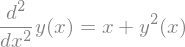

In [35]:
f = y(x)**2 + x
sympy.Eq(y(x).diff(x, x), f)

In [36]:
sympy.dsolve(y(x).diff(x, x) - f, y(x))

NotImplementedError: solve: Cannot solve -x - y(x)**2 + Derivative(y(x), (x, 2))

Dotarliśmy zatem do równania, którego `SymPy` w ogóle nie potrafi rozwiązać. Spróbujemy do tego problemu wrócić później, przy rozwiązaniach numerycznych.

### Przykład.
Rozważmy następujący problem: 

Firma obraca pewnym zasobem (w ilości $x(t)$, porządana ilość to $s$), zaczyna z pewną jego początkową wartością $x_0$, oraz pracuje z dostawcą, który ten zasób zapewnia. Każdego dnia firma prosi dostawcę o zasób w ilości proporcjonalnej (ze stałą $k$) do różnicy między porządaną ilością a aktualną (czyli $s-x$) oraz proporcjonalnie (ze stałą $1$) do zapotrzebowania rynku (stałego, wielkości $d$). Dostawca zapewna zasób zgodnie z wartością zamówienia $y(t)$ (z początkową wartością $y_0$), ze stałym opóźnieniem $p$. 

Firma chciałaby wiedzieć jak będzie zachowywała się ilość zasobu oraz poziom wielkości zamówienia, a także czy można uniknąć oscylującego zachowania tych wielkości.

Konstruujemy układ równań:
$$x'(t) = \frac{1}{p}y(t) - d, \qquad x(0) = x_0,$$
$$y'(t) = -\frac{1}{p}y(t) + d + k(s-x(t)), \qquad y(0) = y_0.$$
Spróbujmy go rozwiązać.

In [37]:
t = sympy.symbols('t')
s, d, k, p = 4, 3, 1.5, 4
x = sympy.Function('x')
y = sympy.Function('y')
f1 = y(t) / p - d
f2 = -y(t) / p + d + k * (s - x(t))

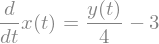

In [38]:
sympy.Eq(x(t).diff(t), f1)

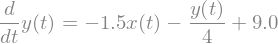

In [39]:
sympy.Eq(y(t).diff(t), f2)

In [40]:
ode_sol = sympy.dsolve([x(t).diff(t) - f1, y(t).diff(t) - f2], ics={x(0): 8, y(0): 14})

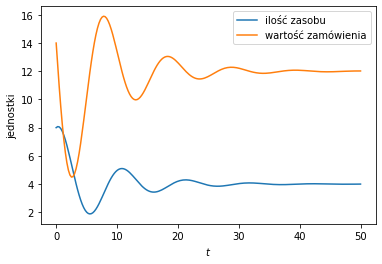

In [41]:
tt = np.linspace(0, 50, 200)
x_t = sympy.lambdify(t, ode_sol[0].rhs, 'numpy')
y_t = sympy.lambdify(t, ode_sol[1].rhs, 'numpy')
plt.plot(tt, x_t(tt), label="ilość zasobu")
plt.plot(tt, y_t(tt), label="wartość zamówienia")
plt.xlabel("$t$")
plt.ylabel("jednostki")
plt.legend()
plt.show()

In [42]:
def zasoby(s, d, k, p, x0, y0):
    t = sympy.symbols('t')
    x = sympy.Function('x')
    y = sympy.Function('y')
    f1 = y(t) / p - d
    f2 = -y(t) / p + d + k * (s - x(t))
    ode_sol = sympy.dsolve([x(t).diff(t) - f1, y(t).diff(t) - f2], ics={x(0): x0, y(0): y0})
    
    tt = np.linspace(0, 50, 200)
    x_t = sympy.lambdify(t, ode_sol[0].rhs, 'numpy')
    y_t = sympy.lambdify(t, ode_sol[1].rhs, 'numpy')
    plt.plot(tt, x_t(tt), label="ilość zasobu")
    plt.plot(tt, y_t(tt), label="wartość zamówienia")
    plt.xlabel("$t$")
    plt.ylabel("jednostki")
    plt.legend()
    plt.show()
   
interact(zasoby, s=widgets.IntSlider(min=1, max=100, step=1, value=4, description="$s$"),
               d=widgets.IntSlider(min=0, max=24, step=1, value=3, description="$d$"),
               k=widgets.FloatSlider(min=0, max=2, step=0.001, value=1.5, description="$k$"),
               p=widgets.FloatSlider(min=0, max=10, step=0.1, value=4, description="$p$"),
               x0=widgets.IntSlider(min=1, max=100, step=1, value=8, description="$x_0$"),
               y0=widgets.IntSlider(min=1, max=100, step=1, value=14, description="$y_0$")
        );

interactive(children=(IntSlider(value=4, description='$s$', min=1), IntSlider(value=3, description='$d$', max=…

### Zadanie 1.
W mieście sprzedawane są domy i klimatyzatory - wiadomo, że są to dobra uzupełniające się, więc ich sprzedaż będzie ze sobą powiązana. Liczba sprzedanych domów ($x(t)$) zmienia się proporcjonalnie do liczby domów, których jeszcze nie sprzedany (łącznie dostępnych jest $h$ domów). Liczba sprzedanych klimatyzatorów ($y(t)$) zmienia się proporcjonalnie do liczby sprzedanych domów, które jeszcze nie mają klimatyzatora. Wiadomo, że dom sprzedaje się średnio w $a$ dni, a klimatyzator średnio w $b$ dni. Chcemy dowiedzieć się jak wygląda sprzedaż tych dwóch dóbr.

Tworzymy układ równań:
$$ x'(t) = \frac{1}{a}(h - x(t)), \qquad x(0) = x_0,$$
$$ y'(t) = \frac{1}{b}(x(t) - y(t)), \qquad y(0) = y_0.$$

## Pola kierunków równań zwyczajnych

Wykres pola kierunków jest prostym, ale i przydatnym narzędziem wizualizacji możliwych rozwiązań równań zwyczajnych 1. rzędu, zwłaszcza w przypadku równan skalarnych oraz autonomiczych układów dwóch równań skalarnych. Aby je wyznaczyć stworzyć wystarczą podstawowe funkcje z pakietu `matplotlib`.

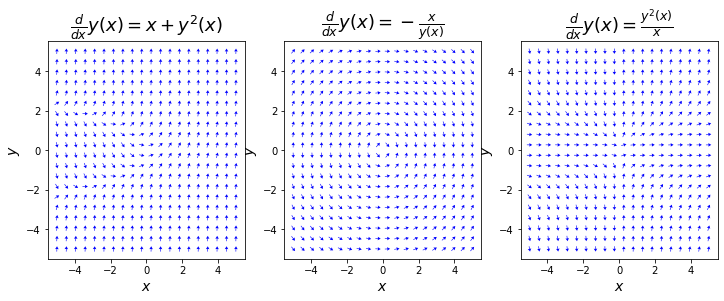

In [44]:
x = sympy.symbols('x')
y = sympy.Function('y')
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# pierwszy przykład
f1 = y(x)**2 + x

f_np = sympy.lambdify((x, y(x)), f1, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# normalizacja
U = U / np.sqrt(U**2 + V**2)
V = V / np.sqrt(U**2 + V**2)

# wyświetlenie wykresu
axes[0].quiver(X, Y, U, V, pivot='mid', headwidth=6, color='blue')
axes[0].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f1)), fontsize = 18)
axes[0].set_xlabel("$x$", fontsize=14)
axes[0].set_ylabel("$y$", fontsize=14)

# drugi przykład
f2 = -x / y(x)

f_np = sympy.lambdify((x, y(x)), f2, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# normalizacja
U = U / np.sqrt(U**2 + V**2)
V = V / np.sqrt(U**2 + V**2)

# wyświetlenie wykresu
axes[1].quiver(X, Y, U, V, pivot='mid', headwidth=6, color='blue')
axes[1].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f2)), fontsize = 18)
axes[1].set_xlabel("$x$", fontsize=14)
axes[1].set_ylabel("$y$", fontsize=14)

# trzeci przykład
f3 = y(x)**2 / x

f_np = sympy.lambdify((x, y(x)), f3, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# normalizacja
U = U / np.sqrt(U**2 + V**2)
V = V / np.sqrt(U**2 + V**2)

# wyświetlenie wykresu
axes[2].quiver(X, Y, U, V, pivot='mid', headwidth=6, color='blue')
axes[2].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f3)), fontsize = 18)
axes[2].set_xlabel("$x$", fontsize=14)
axes[2].set_ylabel("$y$", fontsize=14)
plt.show()

Przy okazji możemy sprawdzić jak dobrze radzi sobie `dsolve` w przypadku równań, których rozwiązanie dane jest szeregiem.

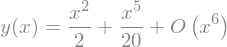

In [45]:
ode_sol = sympy.dsolve(y(x).diff(x) - f1, ics={y(0): 0})
ode_sol

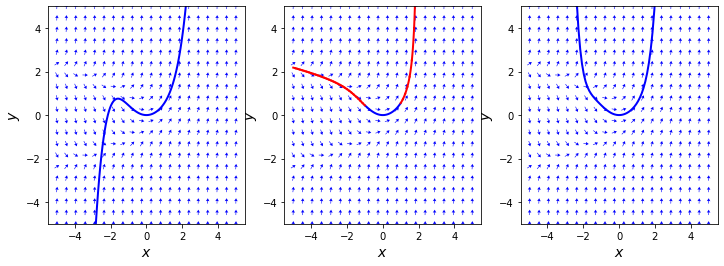

In [46]:
f_np = sympy.lambdify((x, y(x)), f1, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# normalizacja
U = U / np.sqrt(U**2 + V**2)
V = V / np.sqrt(U**2 + V**2)

_, axes = plt.subplots(1, 3, figsize=(12,4))
# wyświetlenie pola kierunków
axes[0].quiver(X, Y, U, V, pivot='mid', headwidth=6, color='blue')
axes[0].set_xlabel("$x$", fontsize=14);
axes[0].set_ylabel("$y$", fontsize=14);

# wyświetlenie rozwiązania
x_vec = np.linspace(-3, 3, 100)
axes[0].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)
axes[0].set_ylim(-5, 5)

# wyświetlenie pola kierunków
axes[1].quiver(X, Y, U, V, pivot='mid', headwidth=6, color='blue')
axes[1].set_xlabel("$x$", fontsize=14);
axes[1].set_ylabel("$y$", fontsize=14);

# wyświetlenie rozwiązania, ale konstruowanego iteracyjnie
x_vec = np.linspace(-1, 1, 100)
axes[1].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)

ode_sol_1 = ode_sol
for x0 in np.arange(1, 2, 0.125):
    x_vec = np.linspace(x0, x0 + 0.125, 100)
    ode_sol_1 = sympy.dsolve(y(x).diff(x) - f1, ics={y(x0): ode_sol_1.rhs.removeO().subs(x, x0)}, n=6)
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_1.rhs.removeO())(x_vec), 'r', lw=2)
ode_sol_1 = ode_sol
for x0 in np.arange(1, 5, 0.125):
    x_vec = np.linspace(- x0 - 0.125, - x0, 100)
    ode_sol_1 = sympy.dsolve(y(x).diff(x) - f1, ics={y(-x0): ode_sol_1.rhs.removeO().subs(x, -x0)}, n=6)
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_1.rhs.removeO())(x_vec), 'r', lw=2)
axes[1].set_ylim(-5, 5)

# wyświetlenie pola kierunków
axes[2].quiver(X, Y, U, V, pivot='mid', headwidth=6, color='blue')
axes[2].set_xlabel("$x$", fontsize=14);
axes[2].set_ylabel("$y$", fontsize=14);

# wyświetlenie rozwiązania, ale obliczonego z większą dokładnością
x_vec = np.linspace(-5, 5, 100)
ode_sol = sympy.dsolve(y(x).diff(x) - f1, ics={y(0): 0}, n=9)
axes[2].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)
axes[2].set_ylim(-5, 5)

plt.show()

Można do zagadnienia pola kierunków podejść też nieco inaczej, tzn. rysując `streamplot`.

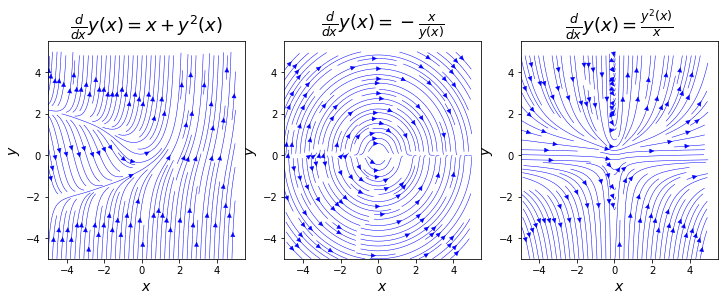

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# pierwszy przykład
f1 = y(x)**2 + x

f_np = sympy.lambdify((x, y(x)), f1, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# wyświetlenie wykresu
axes[0].streamplot(X, Y, U, V, density=1.5, color='blue', linewidth=0.5)
axes[0].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f1)), fontsize = 18)
axes[0].set_xlabel("$x$", fontsize=14)
axes[0].set_ylabel("$y$", fontsize=14)

# drugi przykład
f_np = sympy.lambdify((x, y(x)), f2, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# wyświetlenie wykresu
axes[1].streamplot(X, Y, U, V, density=1.5, color='blue', linewidth=0.5)
axes[1].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f2)), fontsize = 18)
axes[1].set_xlabel("$x$", fontsize=14)
axes[1].set_ylabel("$y$", fontsize=14)

# trzeci przykład
f_np = sympy.lambdify((x, y(x)), f3, 'numpy')
x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = f_np(X, Y)

# wyświetlenie wykresu
axes[2].streamplot(X, Y, U, V, density=1.5, color='blue', linewidth=0.5)
axes[2].set_title(r"$%s$" % sympy.latex(sympy.Eq(y(x).diff(x), f3)), fontsize = 18)
axes[2].set_xlabel(r"$x$", fontsize=14)
axes[2].set_ylabel("$y$", fontsize=14)
plt.show()

Na takim wykresie łatwiej zobaczyć rozwiązanie. Może się też przydać w przypadku układów równań. Wróćmy do przykładu oscylatora Van der Pola (z wykładu):
$$x'' - \mu (1-x^2)x' + x = 0,$$
który można zapisać jako układ równań:
$$x' = y, \qquad y' = \mu (1-x^2)y - x.$$
Niech $\mu=\frac{1}{3}$.

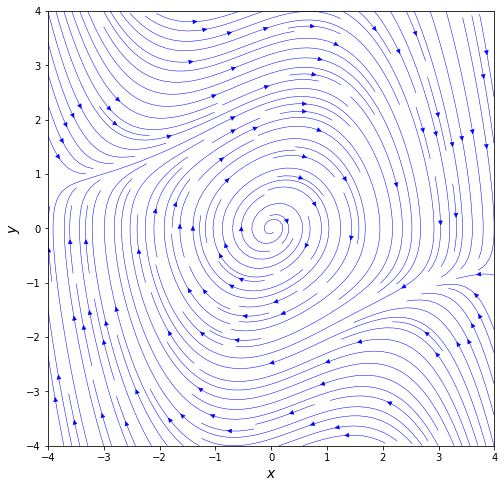

In [48]:
t = sympy.symbols('t')
x = sympy.Function('x')
y = sympy.Function('y')
_, axes = plt.subplots(figsize=(8,8))

fx = y(t)
fy = (1 - x(t)**2) * y(t) / 3 - x(t)

fx_np = sympy.lambdify((x(t), y(t)), fx, 'numpy')
fy_np = sympy.lambdify((x(t), y(t)), fy, 'numpy')
x_np = np.linspace(-4, 4, 20)
y_np = np.linspace(-4, 4, 20)
X, Y = np.meshgrid(x_np, y_np)
U = fx_np(X, Y)
V = fy_np(X, Y)

# wyświetlenie wykresu
axes.streamplot(X, Y, U, V, density=2, color='blue', linewidth=0.5)
axes.set_xlabel("$x$", fontsize=14)
axes.set_ylabel("$y$", fontsize=14)
axes.set_xlim(-4, 4)
axes.set_ylim(-4, 4)

plt.show()

Problem z tym równaniem polega na tym, że niezbyt umiemy sobie z nim poradzić.

In [49]:
ode_sol = sympy.dsolve([x(t).diff(t) - fx, y(t).diff(t) - fy], ics={x(0): 1, y(0): 1})

ValueError: Couldn't solve for initial conditions

Spróbujemy więc podejść do problemu inaczej - numerycznie. Ale to za moment.

### Zadanie 2. 
Na wykładzie i ćwiczeniach omawialiśmy układ równań Lotki-Volterry (czyli model drapieżnik-ofiara):
$$x' = ax - bxy, \qquad y' = dxy - cy,$$
gdzie $x$ to liczność populacji ofiary, $y$ to liczność populacji drapieżnika. Stwórz pole kierunków i sprawdź, czy możliwe jest symboliczne wyznaczenie rozwiązania tego problemu dla następujących danych:
$$ a = 0{,}4,\quad b = 0{,}002,\quad c = 0{,}7,\quad d = 0{,}001,\quad x(0) = 600,\quad y(0) = 400.$$

## Rozwiązywanie numeryczne

Wiemy już jak rozwiązywać równania zwyczajne symbolicznie (o ile się da), pozostaje jednak problem rozwiązywania numerycznego. Odpowiednie funkcje można znaleźć w pakiecie `SciPy` (w module `integrate`) - my posłużymy się funkcją `solve_ivp`, dostępna jest (choć nie jest już polecana) też funkcja `odeint`.

Tym razem nie będziemy się już posługiwać obliczeniami symbolicznymi.

In [52]:
def fun1(x, y):
    "Prawa strona równania y'(x) = y(x)^2 + x"
    return y**2 + x

Istotna jest tutaj kolejność argumentów podawanych funkcji prawej strony: najpierw zmienna niezależna, potem zmienna zależna (może to być wektor).

In [53]:
ode_sol = integrate.solve_ivp(fun1, [0, 2], [0])

In [54]:
print(ode_sol.t)
print(ode_sol.y[0])

[0.00000000e+00 1.00000000e-04 1.10000000e-03 1.11000000e-02
 1.11100000e-01 6.90152577e-01 1.18420544e+00 1.56681729e+00
 1.71204134e+00 1.85726538e+00 1.89398310e+00 1.93070082e+00
 1.95115726e+00 1.96836653e+00 1.97421195e+00 1.98005737e+00
 1.98202062e+00 1.98398388e+00 1.98474786e+00 1.98551184e+00
 1.98575364e+00 1.98599545e+00 1.98609727e+00 1.98619910e+00
 1.98622777e+00 1.98625643e+00 1.98627044e+00 1.98628445e+00
 1.98628758e+00 1.98629070e+00 1.98629270e+00 1.98629425e+00
 1.98629483e+00 1.98629540e+00 1.98629556e+00 1.98629571e+00
 1.98629579e+00 1.98629586e+00 1.98629589e+00 1.98629591e+00
 1.98629592e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.98629593e+00 1.98629593e+00 1.98629593e+00
 1.98629593e+00 1.986295

Warto zwrócić tutaj uwagę na dwie rzeczy: 
* `solve_ivp` automatycznie wybiera sobie punkty, w których daje rozwiązanie,
* zawsze podajemy warunek początkowy na początku przedziału,
* `ode_sol.y` to wektor - w przypadku układów równań dostaniemy kolejne współrzędne rozwiązania.

Możemy wymusić, w jakich punktach mamy otrzymać rozwiązanie, możemy też wymóc zwrócenie rozwiązania "ciągłego".

In [55]:
x_p = np.linspace(0, 1.9, 200)
ode_sol_p = integrate.solve_ivp(fun1, [0, 1.9], [0], t_eval=x_p)

In [56]:
x_m = np.linspace(0, -5, 200)
ode_sol_m = integrate.solve_ivp(fun1, [0, -5], [0], t_eval=x_m)

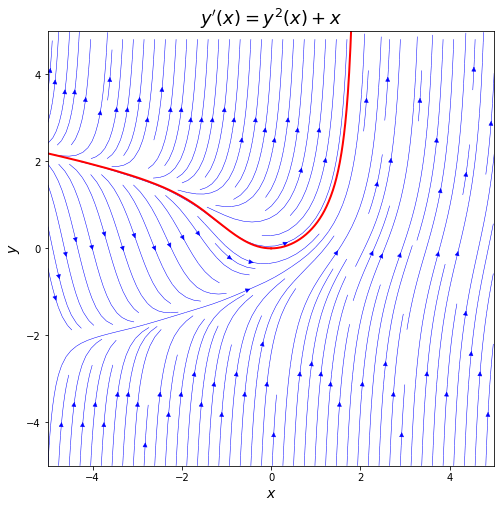

In [57]:
_, axes = plt.subplots(figsize=(8,8))

x_np = np.linspace(-5, 5, 20)
y_np = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x_np, y_np)
U = np.ones((20,20))
V = Y**2 + X

# wyświetlenie wykresu
axes.streamplot(X, Y, U, V, density=1.5, color='blue', linewidth=0.5)
axes.plot(x_p, ode_sol_p.y[0], 'r', lw=2)
axes.plot(x_m, ode_sol_m.y[0], 'r', lw=2)
axes.set_title("$y'(x) = y^2(x) + x$", fontsize = 18)
axes.set_xlabel("$x$", fontsize=14)
axes.set_ylabel("$y$", fontsize=14)
axes.set_xlim(-5, 5)
axes.set_ylim(-5, 5)

plt.show()

Domyślnie używana jest metoda RK45, czyli metoda Runge-Kutty rzędu 5(4) - błąd jest kontrolowany za pomocą metody rzędu 4, ale kroki są dobierane z wykorzystaniem metody rzędu 5. Można jednak wybrać też inną metodę za pomocą argumentu `method='RK45'` lub innego ciągu znaków (dostępne np. `'RK23'`, `'DOP853'`, `'Radau'`, `'BDF'` lub `'LSODA'`). Można zdefiniować również własną metodę.

Rozważmy nieco bardziej skomplikowany model - wahadła na sprężynie. Mamy masę $m$ wiszącą na sprężynie (o stałej sprężystości $k$), która w stanie równowagi ma długość $L_1$. Funkcjami, które będą opisywały ruch zawieszonej masy są:
* odległość od położenia równowagi (wzdłuż prostej łączącej z punktem zaczepienia, czyli długość sprężyny$-L_1$) $L(t)$,
* kąt odchylenia od pionu $\theta(t)$.

Mamy wówczas układ równań: \begin{align*}
L'' &= (L_1 + L)(\theta')^2 - \frac{k}{m}L + g\cos\theta, &\qquad L(0) &= L_0,&\, L'(0) &= v_0, \\
\theta'' &= -\frac{1}{L_1 + L}(g\sin\theta + 2L'\theta'), &\qquad \theta(0) &= \theta_0,&\, \theta'(0) &= \omega_0.
\end{align*}

Jest to układ równań II rzędu, więc musimy go sprowadzić do układu czterech równań pierwszego rzędu: \begin{align*}
L' &= v, &\qquad L(0) &= L_0, \\
v' &= (L_1 + L)\omega^2 - \frac{k}{m}L + g\cos\theta, &\qquad v(0) &= v_0, \\
\theta' &= \omega, &\qquad \theta(0) &= \theta_0, \\
\omega' &= -\frac{1}{L_1 + L}(g\sin\theta + 2v\omega), &\qquad \omega(0) &= \omega_0.
\end{align*}

In [58]:
def fun2(t, y, m, k, g, L1):
    "Prawa strona układu równań wahadła na sprężynie."
    L, v, theta, omega = y
    y0 = v
    y1 = (L1 + L) * omega**2 - k * L / m + g * np.cos(theta)
    y2 = omega
    y3 = - (g * np.sin(theta) + 2 * v * omega) / (L1 + L)
    return [y0, y1, y2, y3]

In [59]:
m, k, g, L1 = 0.2, 3.5, 9.8, 1.0
L0, v0, theta0, omega0 = 1.0, 0.0, np.pi/12, 0.0
t = np.linspace(0, 25, 1000)
ode_sol = integrate.solve_ivp(fun2, [0, 25], [L0, v0, theta0, omega0], args=(m, k, g, L1), dense_output=True)

Gdy funkcja ma zwrócić jako wynik funkcję ciągłą (czyli interpolowaną), to nie trzeba już podawać punktów.

Żeby móc zwizualizować wynik to dobrze by było nieco go przekształcić - mamy tutaj do czynienia ze współrzędnymi biegunowymi, a nie kartezjańskimi.

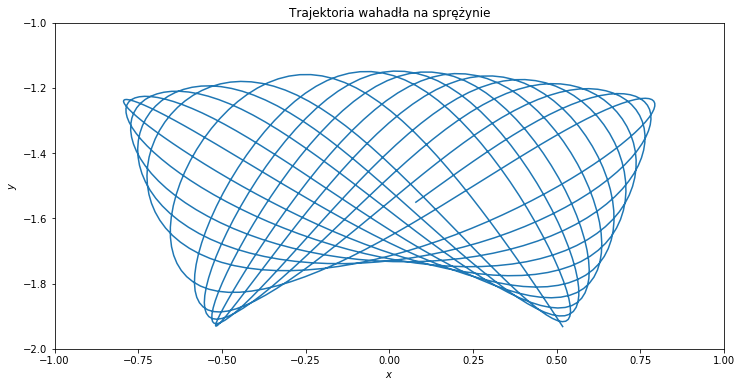

In [60]:
_, axes = plt.subplots(figsize=(12,6))

x = (ode_sol.sol(t)[0] + L1) * np.sin(ode_sol.sol(t)[2])
y = - (ode_sol.sol(t)[0] + L1) * np.cos(ode_sol.sol(t)[2])
axes.plot(x, y)
axes.set_xlabel("$x$")
axes.set_ylabel("$y$")
axes.set_title("Trajektoria wahadła na sprężynie")
axes.set_xlim(-1, 1)
axes.set_ylim(-2, -1)
plt.show()

### Zadanie 3.
Rozwiąż numerycznie układ równań Lotki-Volterry z Zadania 2, następnie stwórz wykres rozwiązań (zależności $x(t)$ i $y(t)$), a także nanieś na pole kierunków trajektorię rozwiązania.

Rozważmy na koniec jeszcze jeden problem - zmodyfikowany model drapieżnik-ofiara, który uwzględni też pojemność środowiska oraz pewien czas reakcji na zmiany. Mamy wówczas układ: \begin{align*}
x' &= x \left(a - \frac{b}{1+bhx}y - \frac{a}{K}x\right), &\qquad x(0) &= x_0, \\
y' &= y \left(-c + \frac{db}{1+bhx}x\right), &\qquad y(0) &= y_0,
\end{align*} gdzie:
* $a$ - tempo wzrostu populacji ofiar,
* $b$ - tempo zjadania ofiar przez drapieżniki, 
* $K$ - pojemność populacji ofiar w środowisku, 
* $c$ - tempo umierania populacji drapieżników,
* $d$ - tempo "przetwarzania" ofiar na drapieżniki,
* $h$ - stała czasowa reakcji.

Układ ten ma trzy punkty równowagi:
* obie populacje wymrą,
* drapieżniki wyginą, a ofiary dojdą do maksymalnej wielkości populacji,
* osiągnięty zostanie nietrywialny stan równowagi, w którym obie populacje koegzystują.

In [65]:
def fun4(t, z, a, b, K, c, d, h):
    "Prawa strona zmodyfikowanego układu równań Lotki-Volterry."
    x, y = z
    z0 = x * (a - b * y / (1 + b * h * x) - a * x / K)
    z1 = y * (- c + d * b * x / (1 + b * h * x))
    return [z0, z1]

In [66]:
a, b, K, c, d, h = 0.5, 0.005, 2000, 0.1, 0.5, 0.1
xy0 = [204, 406]
t = np.linspace(0, 150, 1000)
ode_sol = integrate.solve_ivp(fun4, [0, 150], xy0, args=(a, b, K, c, d, h), dense_output=True)

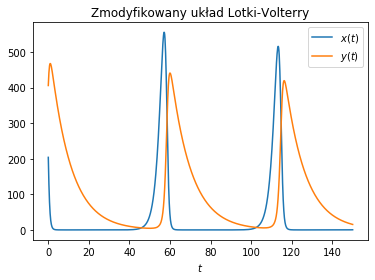

In [67]:
plt.plot(t, ode_sol.sol(t).T)
plt.xlabel("$t$")
plt.legend(["$x(t)$", "$y(t)$"])
plt.title("Zmodyfikowany układ Lotki-Volterry")
plt.show()

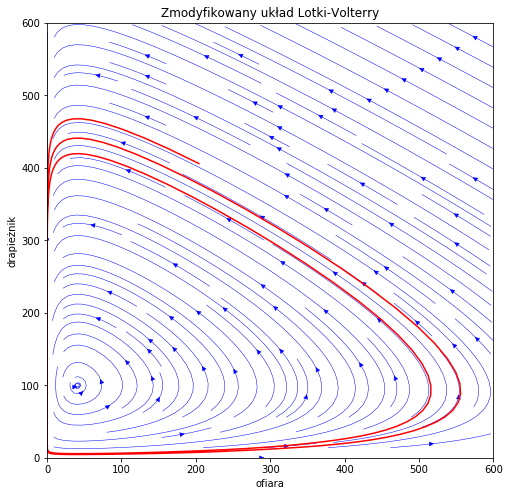

In [68]:
_, axes = plt.subplots(figsize=(8, 8))

X, Y = np.meshgrid(np.linspace(0, 600, 40), np.linspace(0, 600, 40))
U, V = fun4(_, (X, Y), a, b, K, c, d, h)

axes.streamplot(X, Y, U, V, density=1.5, color='blue', linewidth=0.5)
axes.plot(ode_sol.sol(t)[0], ode_sol.sol(t)[1], 'r')
axes.set_xlabel("ofiara")
axes.set_ylabel("drapieżnik")
axes.set_title("Zmodyfikowany układ Lotki-Volterry")
axes.set_xlim(0, 600)
axes.set_ylim(0, 600)
plt.show()

Widać, że układ zmierza do cyklu. Można jednak odrobinę zmienić jeden parametr (pojemność środowiska), by układ zachowywał się zupełnie inaczej.

In [69]:
a, b, K, c, d, h = 0.5, 0.005, 200, 0.1, 0.5, 0.1
xy0 = [204, 406]
t = np.linspace(0, 150, 1000)
ode_sol = integrate.solve_ivp(fun4, [0, 150], xy0, args=(a, b, K, c, d, h), dense_output=True)

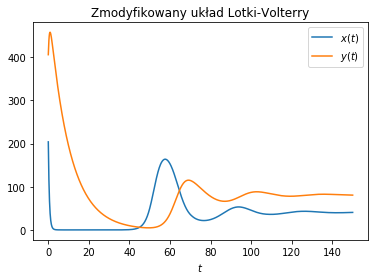

In [70]:
plt.plot(t, ode_sol.sol(t).T)
plt.xlabel("$t$")
plt.legend(["$x(t)$", "$y(t)$"])
plt.title("Zmodyfikowany układ Lotki-Volterry")
plt.show()

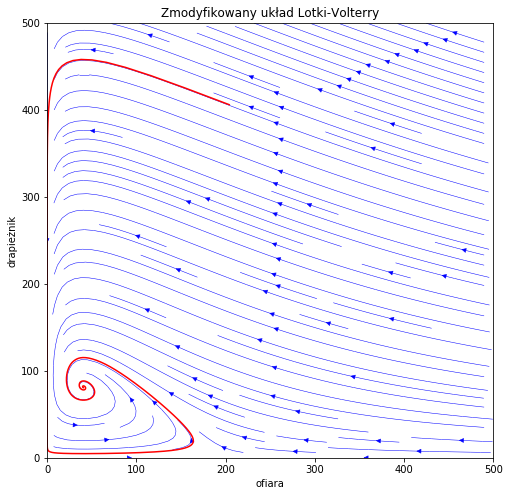

In [71]:
_, axes = plt.subplots(figsize=(8, 8))

X, Y = np.meshgrid(np.linspace(0, 500, 40), np.linspace(0, 500, 40))
U, V = fun4(_, (X, Y), a, b, K, c, d, h)

axes.streamplot(X, Y, U, V, density=1.5, color='blue', linewidth=0.5)
axes.plot(ode_sol.sol(t)[0], ode_sol.sol(t)[1], 'r')
axes.set_xlabel("ofiara")
axes.set_ylabel("drapieżnik")
axes.set_title("Zmodyfikowany układ Lotki-Volterry")
axes.set_xlim(0, 500)
axes.set_ylim(0, 500)
plt.show()

Można stąd wyciągnąć ciekawy wniosek - system, który jest początkowo stabilny, może zupełnie zmienić swoje zachowanie, gdy tylko da się więcej zasobów ofiarom, albo ograniczy efektywność drapieżników. 